# Fundamentals and Challenges of Generative Adversarial Networks for Image-based Applications
## SIBGRAPI 2022 Tutorial

Authors: Vinicius Luis Trevisan de Souza, Bruno Augusto Dorta Marques, João Paulo Gois

Universidade Federal do ABC (UFABC) - Centro de Matemática, Computação e Cognição

Full or partial reproduction is prohibited without the permission of the authors

# 2 - DCGAN

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf

In [3]:
from IPython import display

## Configs

In [4]:
BUFFER_SIZE = 500
BATCH_SIZE = 128
IMG_SIZE = 64
OUTPUT_CHANNELS = 3
VECTOR_SIZE = 100
LEARNING_RATE = 2e-4
ADAM_BETA1 = 0.5

In [5]:
EPOCHS = 20

## Dataset

In [6]:
# Preprocess pipeline
def image_preprocess_train(image_file, img_size):
    """Loads a sample image for training"""
    
    # Format preprocessing
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)

    # Resize the image, if needed
    if image.shape[0] != img_size:
        image = tf.image.resize(image, [img_size, img_size])

    # Nomalize the images to the interval [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    return image

In [7]:
# String of the dataset folder path
dataset_folder = 'Datasets/dcgan_dataset/data/'

In [8]:
# Create the dataset from the images on the folder
dataset = tf.data.Dataset.list_files(dataset_folder + '*.jpg')

In [9]:
# Check how many images are there
dataset_size = len(list(dataset))
dataset_size

4500

In [10]:
# Apply the preprocessing
dataset = dataset.map(lambda x: image_preprocess_train(x, IMG_SIZE))

In [11]:
# Caches the dataset
dataset = dataset.cache()

In [12]:
# Shuffle the dataset and split in batches
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

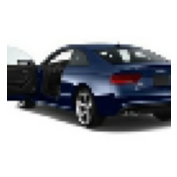

In [13]:
# Displays a sample image
for img in dataset.take(1):
    # Takes only one image from the batch
    img = img[0]
    # Brings back the image to the [0, 1] range
    img = img * 0.5 + 0.5
    # Plots the image
    plt.figure(figsize = (3, 3))
    plt.imshow(img)
    # Getting the axis off
    plt.axis('off')

## Network

### Generator

In [14]:
normal_initializer = tf.random_normal_initializer(0., 0.02)

In [15]:
def generator(VECTOR_SIZE, OUTPUT_CHANNELS):
    
    # Defining the highest number of filters
    filters = 512

    # Defining the inputs
    inputs = tf.keras.layers.Input(shape=[VECTOR_SIZE])
    
    """
    The first layer of the GAN, which takes a uniform noise distribution Z as input, could be called
    fully connected as it is just a matrix multiplication, but the result is reshaped into a 4-dimensional
    tensor and used as the start of the convolution stack
    """
    
    x = inputs
    x = tf.keras.layers.Dense(filters*4*4, use_bias = False, kernel_initializer=normal_initializer)(x)
    x = tf.keras.layers.Reshape([4, 4, filters])(x)
    
    # Creating the network with Keras Functional API
    x = tf.keras.layers.Conv2DTranspose(filters/2, 5, strides = 2, padding = 'same', use_bias=False, kernel_initializer=normal_initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(filters/4, 5, strides = 2, padding = 'same', use_bias=False, kernel_initializer=normal_initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(filters/8, 5, strides = 2, padding = 'same', use_bias=False, kernel_initializer=normal_initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 5, strides = 2, padding = 'same', use_bias=False, kernel_initializer=normal_initializer)(x)
    x = tf.keras.layers.Activation('tanh')(x)
    
    # Returns the model
    return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
gen = generator(VECTOR_SIZE, OUTPUT_CHANNELS)

In [17]:
gen.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 8192)              819200    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3276800   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 8, 8, 256)         0     

### Discriminator

In [18]:
def discriminator(IMG_SIZE, OUTPUT_CHANNELS):

    # Defining the highest number of filters
    filters = 512
    
    # Defining the inputs
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS])
    x = inputs
    
    # Creating the network with Keras Functional API
    x = tf.keras.layers.Conv2D(filters/8, 5, strides = 2, padding = 'same', use_bias=False, kernel_initializer=normal_initializer)(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(filters/4, 5, strides = 2, padding = 'same', use_bias=False, kernel_initializer=normal_initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    
    # Returns the model
    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
disc = discriminator(IMG_SIZE, OUTPUT_CHANNELS)

In [20]:
disc.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4800      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204800    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                           

### Optimizers

In [21]:
g_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1 = ADAM_BETA1)

In [22]:
d_opt = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1 = ADAM_BETA1)

## Losses

In [23]:
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
# Generator adversarial loss
@tf.function
def generator_loss(disc_fake):
    gen_loss = BCE(tf.ones_like(disc_fake), disc_fake)
    return gen_loss

In [25]:
# Discriminator adversarial loss
@tf.function
def discriminator_loss(disc_real, disc_fake):
    real_loss = BCE(tf.ones_like(disc_real), disc_real)
    fake_loss = BCE(tf.zeros_like(disc_fake), disc_fake)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss, real_loss, fake_loss

## Training Functions

In [26]:
def train_step(gen, disc, g_opt, d_opt, real_sample, noise):
    
    # Starting the tape to record the gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # Generating the fake sample from the noise
        fake_sample = gen(noise, training=True)
        
        # Discriminating both samples
        disc_fake = disc(fake_sample, training=True)
        disc_real = disc(real_sample, training=True)
        
        # Evaluating the losses
        gen_loss = generator_loss(disc_fake)
        disc_loss, disc_real_loss, disc_fake_loss = discriminator_loss(disc_real, disc_fake)
        
    # Evaluating the gradients
    gen_gradients = gen_tape.gradient(gen_loss, gen.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
    
    # Updating the parameters of the networks through backpropagation
    g_opt.apply_gradients(zip(gen_gradients, gen.trainable_variables))
    d_opt.apply_gradients(zip(disc_gradients, disc.trainable_variables))
    
    # Returning the losses
    loss_dict = {
        'gen_loss': gen_loss,
        'disc_loss': disc_loss,
        'disc_real_loss': disc_real_loss,
        'disc_fake_loss': disc_fake_loss,
    }
    
    return loss_dict

In [27]:
def fit(gen, disc, g_opt, d_opt, dataset, epochs, batch_size, vector_size):
    
    # Prepares the progression bar
    n_iterations = len(list(dataset.as_numpy_iterator()))
    progbar = tf.keras.utils.Progbar(n_iterations)

    # Logs for the gen and disc losses
    gen_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    
    for epoch in range(epochs):
        
        display.clear_output(wait=True)
        plot_images(gen, 16)
        
        
        print(f"Epoch: {epoch + 1}")
        
        for n, real_sample in dataset.enumerate():
            # Updates the progress bar
            i = n.numpy() + 1  # Adjustment because n starts in 0
            progbar.update(i)
            
            # Generates a random normal noise
            noise = tf.random.normal([BATCH_SIZE, VECTOR_SIZE])
            
            # Perform a train step
            losses = train_step(gen, disc, g_opt, d_opt, real_sample, noise)
            
            # Store the logs of the losses
            gen_losses.append(losses['gen_loss'].numpy())
            disc_losses.append(losses['disc_loss'].numpy())
            disc_real_losses.append(losses['disc_real_loss'].numpy())
            disc_fake_losses.append(losses['disc_fake_loss'].numpy())
            
        print(f"Gen loss: {losses['gen_loss']:.3f} \t Disc loss: {losses['disc_loss']:.3f}\n")
        
        
            
    # Returns the losses
    loss_dict = {
        'gen_loss': gen_losses,
        'disc_loss': disc_losses,
        'disc_real_loss': disc_real_losses,
        'disc_fake_loss': disc_fake_losses,
    }
    
    return loss_dict

In [28]:
def plot_images(model, n_images):
    
    noise = tf.random.normal([n_images, VECTOR_SIZE])
    predictions = model(noise, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)
        plt.axis('off')
        
    plt.show()

## Execution

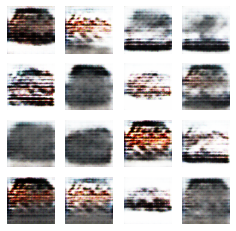

Epoch: 20
36/36 [==============================] - 83s 100ms/step
Gen loss: 0.688 	 Disc loss: 1.273



In [29]:
losses = fit(gen, disc, g_opt, d_opt, dataset, EPOCHS, BATCH_SIZE, VECTOR_SIZE)

Text(0.5, 1.0, 'Losses')

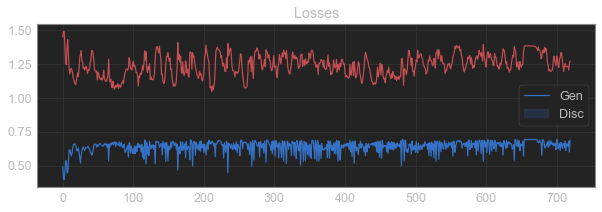

In [30]:
plt.figure(figsize = (10, 3))
sns.lineplot(y = losses['gen_loss'], x = list(range(len(losses['gen_loss']))), color = 'b')
sns.lineplot(y = losses['disc_loss'], x = list(range(len(losses['disc_loss']))), color = 'r')
plt.legend(['Gen', 'Disc'])
plt.title("Losses")

Text(0.5, 1.0, 'Discriminator Losses')

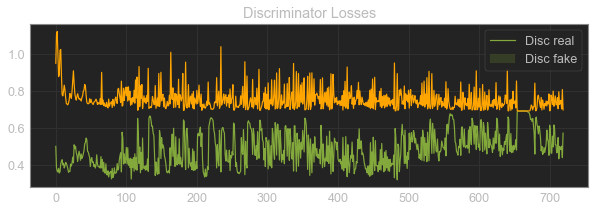

In [31]:
plt.figure(figsize = (10, 3))
sns.lineplot(y = losses['disc_real_loss'], x = list(range(len(losses['disc_real_loss']))), color = 'g')
sns.lineplot(y = losses['disc_fake_loss'], x = list(range(len(losses['disc_fake_loss']))), color = 'orange')
plt.legend(['Disc real', 'Disc fake'])
plt.title("Discriminator Losses")

## Results

In [32]:
# Generates 9 sample noises
noise = np.random.normal(0, 1, [9, VECTOR_SIZE])

In [33]:
# Generates images from those noise inputs
fake_data = gen(noise, training=False)

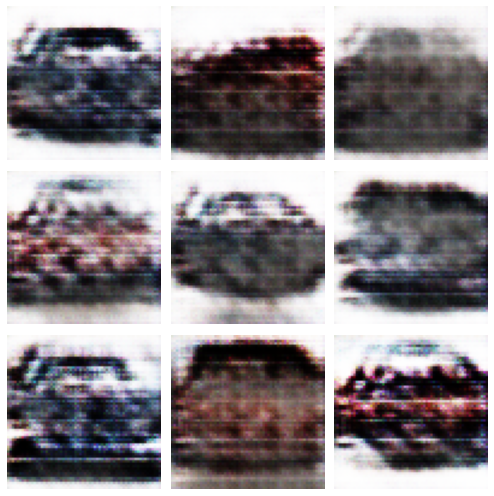

In [34]:
# Shows them all
plt.figure(figsize = (7,7))
for c, img in enumerate(fake_data):
    # Brings back the image to the [0, 1] range
    img = img * 0.5 + 0.5
    # Plotting the image
    plt.subplot(3, 3, c + 1)
    plt.imshow(img)
    # Getting the axis off
    plt.axis('off')
plt.tight_layout()